In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
from sklearn.cluster import KMeans
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc
from functools import reduce

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from src import crs, PublicPredictor, PrevPublicPredictor
from IPython.display import clear_output, Markdown, display

In [5]:
# 1. load_excel
data_path = "data/apt_all.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [6]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)
m.head()

/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datas_df[household_name] = household_df[col][3:].to_list()
/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  month_usage_df[name] = [


,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트4-104-101,아파트4-104-1301,아파트4-104-1501,아파트4-104-301,아파트4-105-102,아파트4-105-103,아파트4-105-1102,아파트4-105-1104,아파트4-105-601,아파트4-105-803
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,335,363,181,216,270,518,230,279,161,156
2,251,481,177,218,397,297,339,197,348,288,...,309,339,146,184,267,344,208,236,167,150
3,255,424,203,222,378,303,349,202,357,368,...,313,372,152,236,268,417,212,272,166,155
4,252,355,180,230,368,278,298,188,346,365,...,266,346,149,210,268,421,208,243,156,148
5,230,357,258,203,414,270,418,156,320,265,...,305,256,151,222,287,349,185,284,165,180


# 최신 버전
- 전기요금계 가격이 1000원 미만일 경우 1000원으로 최저요금으로 맞추어 버리는 경우가 있음.
- 그래서 해당 가구들은 수거 과정에서 제외 시켜야 함
    - 기본요금, 전력량요금 : 수거 과정에서 제외
    - 필수사용량보장공제 : 제외
    - 기후환경요금, 연료비조정액 : 수거 과정에서 제외했으므로, 해당 단계도 세대부 사용량에서 제외하고 percentage 진행

In [28]:
predict_test = pd.DataFrame(columns=['실제 요금', '예측 요금', '오차'])
households_columns = list()

for _ in range(0, 1000):
    n = ran.randrange(50, len(m.columns) + 1)
    _m = m.sample(n=n, axis=1)
    _month = ran.randrange(1, 13)

    month_df = pd.DataFrame(_m.loc[_month])
    month_df.reset_index(inplace=True)
    month_df.columns = ['name', 'usage (kWh)']
    
    PUBLIC_PERCENTAGE = ran.randrange(10, 60)
    households_kWh = month_df['usage (kWh)'].sum()
    APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))
    
    # 예측 시뮬레이션
    pp = PublicPredictor(
        APT=APT,
        month_df=month_df,
        month=_month
    )

    predict_test = predict_test.append(pp.predict, ignore_index=True)
    households_columns.append((PUBLIC_PERCENTAGE,_month,month_df['name'].values))

In [29]:
max_err = predict_test['오차'].abs().max()
min_err = predict_test['오차'].abs().min()
predict_rate = predict_test.apply(lambda x: 
   x['예측 요금'] / x['실제 요금'] * 100 if x['실제 요금'] > x['예측 요금'] 
   else x['실제 요금'] / x['예측 요금'] * 100
   , axis=1).mean()
display(Markdown("# 공용부 요금 예측 시뮬레이션 결과 입니다.\n\n"))

print("• 최고 오차 : {}원".format(format(max_err,",")))
print("• 최소 오차 : {}원".format(format(min_err,",")))
print("• 평균 적중률 : {}%".format(format(predict_rate,",")))

predict_test.head()

# 공용부 요금 예측 시뮬레이션 결과 입니다.



• 최고 오차 : 4,750원
• 최소 오차 : 410원
• 평균 적중률 : 99.93125691478802%


,실제 요금,예측 요금,오차
0,946900,945780,1120
1,6154480,6152570,1910
2,12220990,12218690,2300
3,4180600,4179450,1150
4,2034280,2031180,3100


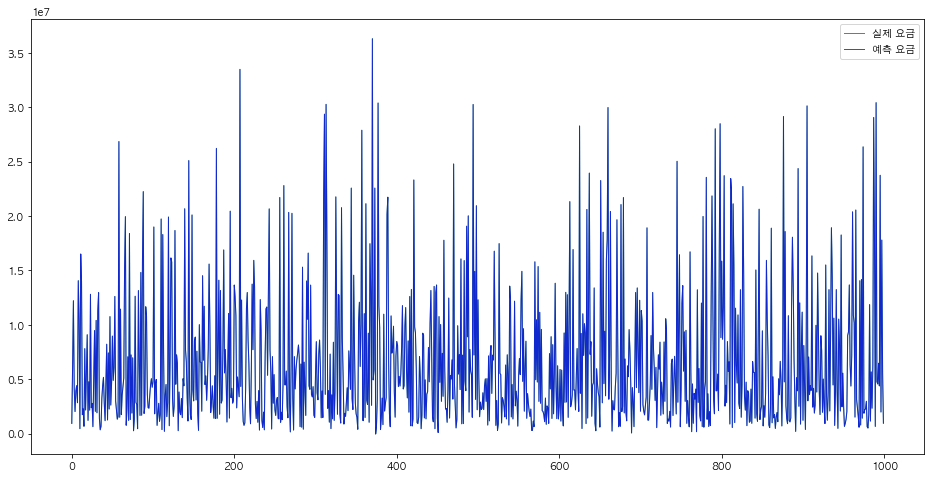

In [41]:
plt.figure(figsize=(16,8))

plt.plot(predict_test['실제 요금'], color='g', linewidth=1, label='실제 요금', alpha=0.75)
plt.plot(predict_test['예측 요금'], color='b', linewidth=1, label='예측 요금', alpha=0.75)

plt.legend(loc='upper right')

plt.show()

# 예전 버전
- 최고오차가 엄청 크게 나오는 현상 발생

In [30]:
prev_predict_test = pd.DataFrame(columns=['실제 요금', '예측 요금', '오차'])
households_columns = list()

for _ in range(0, 1000):
    n = ran.randrange(50, len(m.columns) + 1)
    _m = m.sample(n=n, axis=1)
    _month = ran.randrange(1, 13)

    month_df = pd.DataFrame(_m.loc[_month])
    month_df.reset_index(inplace=True)
    month_df.columns = ['name', 'usage (kWh)']
    
    PUBLIC_PERCENTAGE = ran.randrange(10, 60)
    households_kWh = month_df['usage (kWh)'].sum()
    APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

    pp = PrevPublicPredictor(
        APT=APT,
        month_df=month_df,
        month=_month
    )

    prev_predict_test = prev_predict_test.append(pp.predict, ignore_index=True)
    households_columns.append((PUBLIC_PERCENTAGE,_month,month_df['name'].values))

In [31]:
max_err = prev_predict_test['오차'].abs().max()
min_err = prev_predict_test['오차'].abs().min()
predict_rate = prev_predict_test.apply(lambda x: 
   x['예측 요금'] / x['실제 요금'] * 100 if x['실제 요금'] > x['예측 요금'] 
   else x['실제 요금'] / x['예측 요금'] * 100
   , axis=1).mean()

display(Markdown("# 공용부 요금 예측 시뮬레이션 결과 입니다.\n\n"))

print("• 최고 오차 : {}원".format(format(max_err,",")))
print("• 최소 오차 : {}원".format(format(min_err,",")))
print("• 평균 적중률 : {}%".format(format(predict_rate,",")))

prev_predict_test.head()

# 공용부 요금 예측 시뮬레이션 결과 입니다.



• 최고 오차 : 231,060원
• 최소 오차 : 0원
• 평균 적중률 : 97.91351801873833%


,실제 요금,예측 요금,오차
0,3035930,3035390,540
1,640480,639650,830
2,8677730,8676730,1000
3,11505500,11518830,-13330
4,3124140,3123260,880
